In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet
from pmdarima.arima.utils import ndiffs

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [3]:
df = pd.read_csv('international-airline-passengers.csv')

In [4]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.columns = ['year','passengers']

In [6]:
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [7]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


# Data Preprocessing and visualization

In [8]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [9]:
y=df.set_index('year')

In [10]:

y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [11]:
y.isnull().sum()

passengers    0
dtype: int64

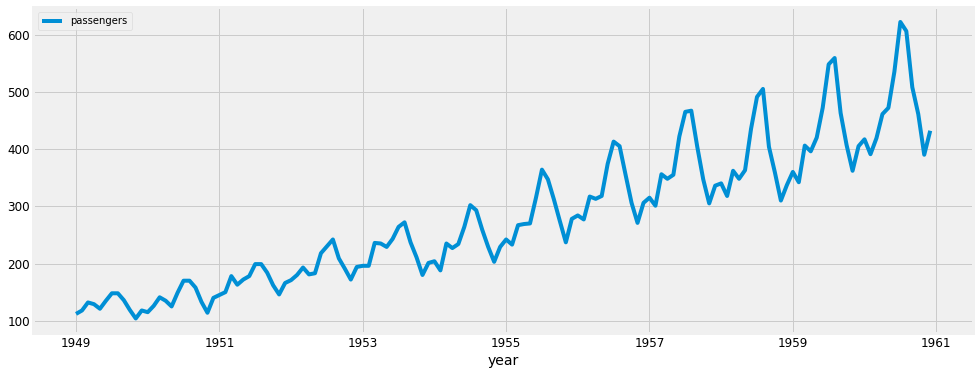

In [12]:
y.plot(figsize=(15, 6))
plt.show()

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- Clear trend and seasonality
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

__Decomposing using statsmodel:__
- We can use statsmodels to perform a decomposition of this time series. 
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. 
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

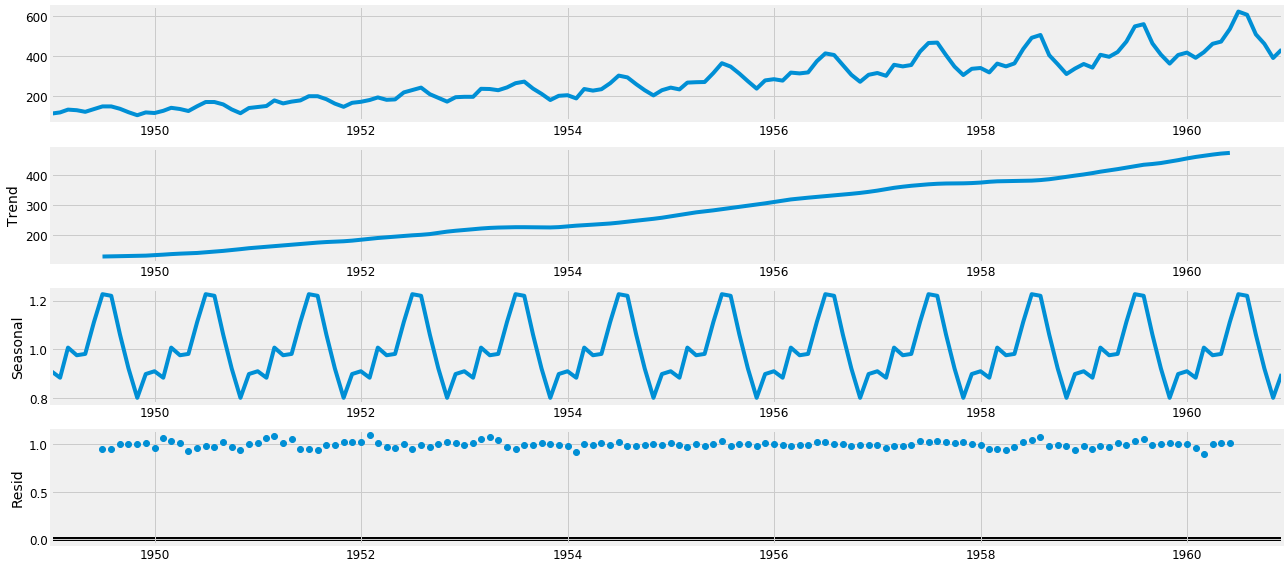

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

## Stationarity
__We can check stationarity using the following:__

- __ACF and PACF plots__: If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

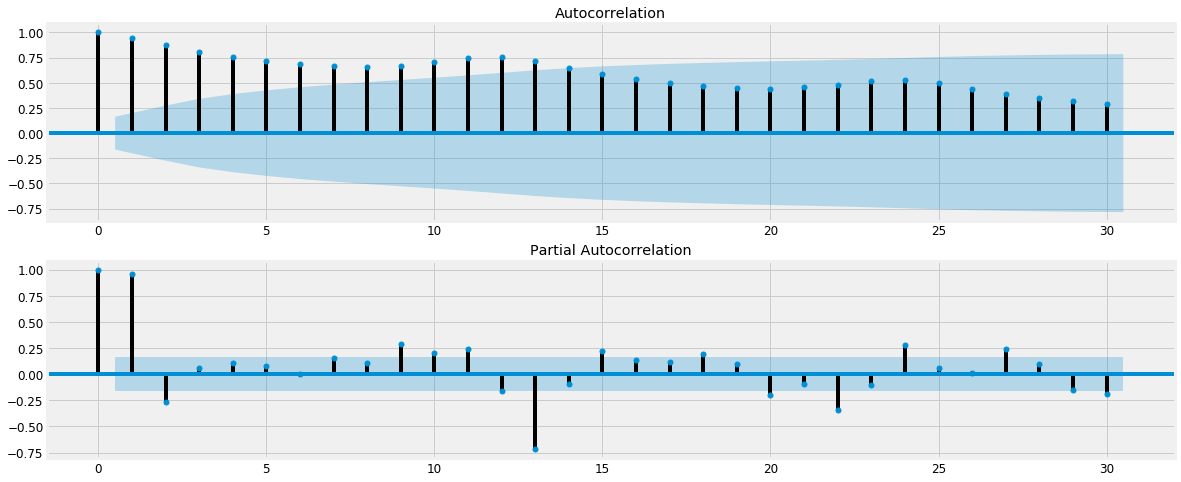

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Plotting Rolling Statistics
- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

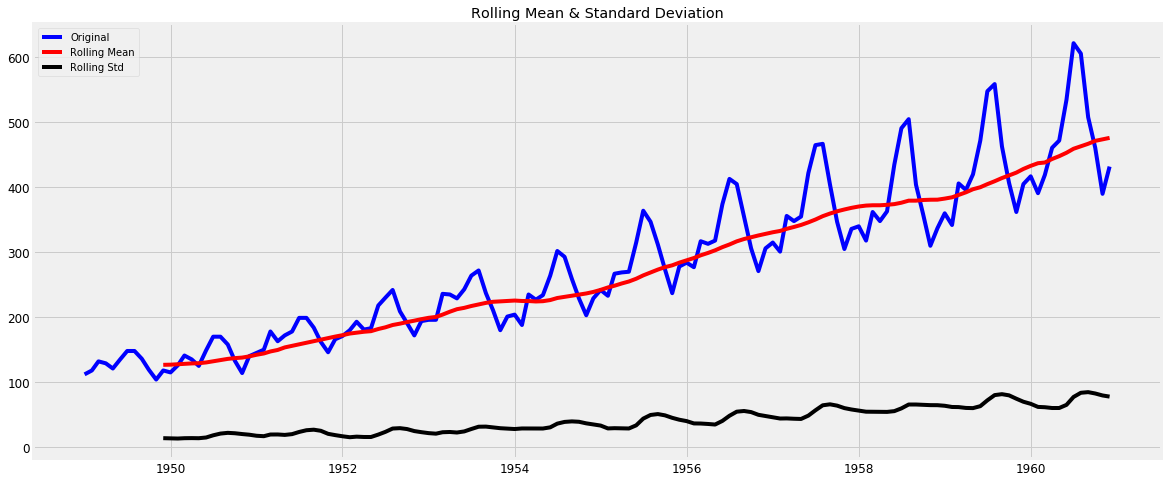

In [15]:
#Determing rolling statistic
rolmean=y.rolling(12).mean()
rolstd=y.rolling(12).std()
#rolmean = pd.rolling(y, window=12).mean()
#rolstd = pd.rolling_std(y, window=12)

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented Dickey-Fuller Test
- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1)  will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

We can clearly see that the there is a significant positive trend. So we can applyApplying log transformation to penalize higher values more than smaller values

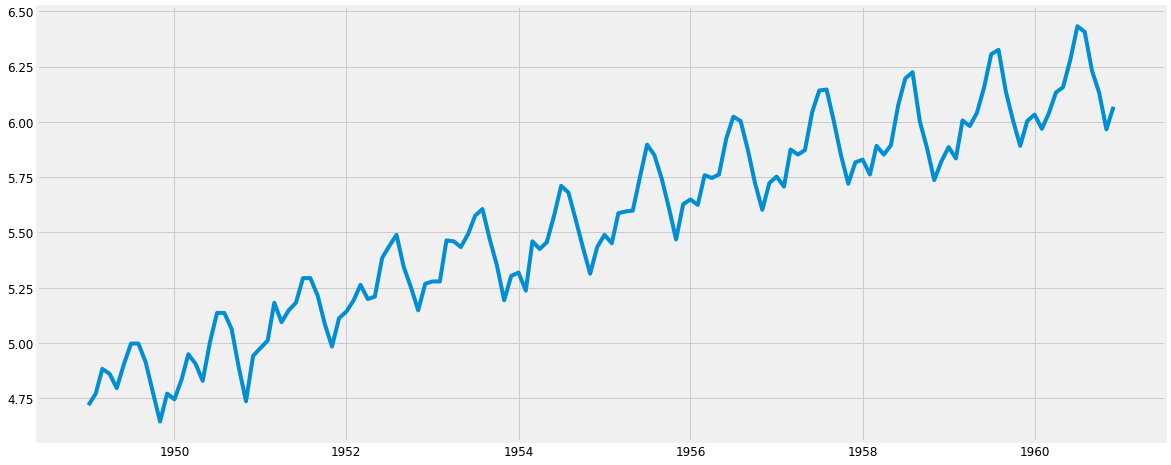

In [19]:
ts_log = np.log(y)
plt.plot(ts_log)

__Detrending using MA__

In [20]:
y1 = y.copy()
y1["logpass"] = np.log(y1.passengers)
y1.head()

,passengers,logpass
year,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


Text(0.5, 1.0, 'Residual after detrending, remaining ssr: 2.221')

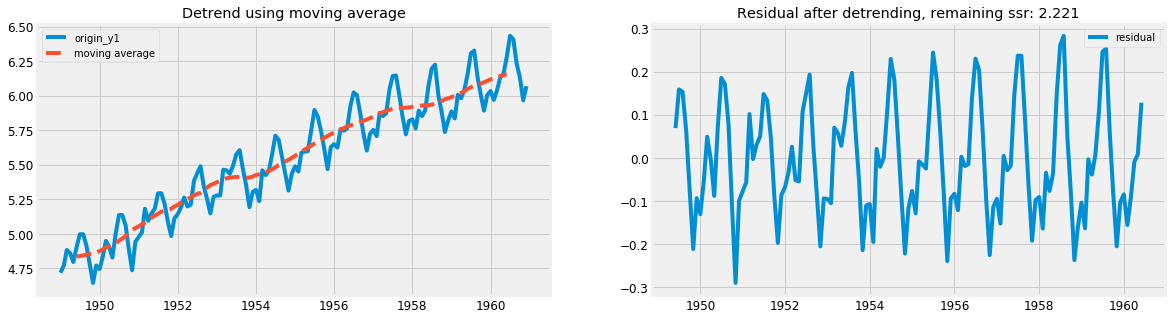

In [21]:
#Using 12 months' average for moving average smoothing
y1["ma"] = y1["logpass"].rolling(12).mean().shift(-6)
y1["residual_1"] = y1["logpass"]-y1["ma"]
plt.subplots(1,2,figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(y1.index,y1["logpass"],"-",label="origin_y1")
plt.plot(y1.index,y1["ma"],"--",label="moving average")
plt.grid(True)
plt.title("Detrend using moving average")
plt.legend()
plt.subplot(1,2,2)
plt.plot(y1.index,y1["residual_1"],"-",label="residual")
plt.grid(True)
plt.legend()
ssr_residual = sum([x**2 for x in y1["residual_1"].dropna()])
plt.title("Residual after detrending, remaining ssr: %.3f"%ssr_residual)

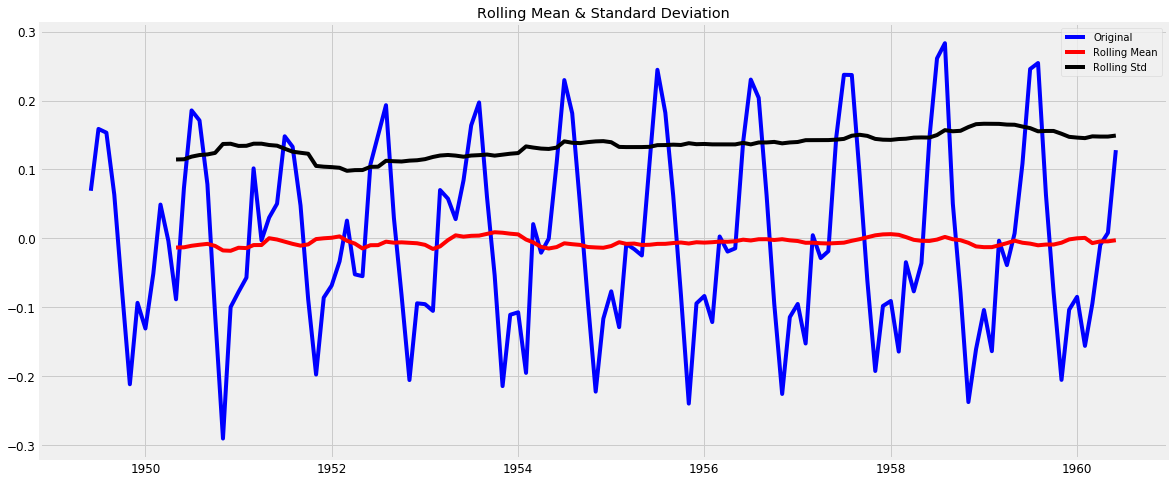

Results of Dickey-Fuller Test:
Test Statistic                  -4.538537
p-value                          0.000167
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [22]:
test_stationarity( y1["residual_1"].dropna())

__Detrending using Linear Regression__

Text(0.5, 1.0, 'Residual after detrending, remaining ssr: 2.745')

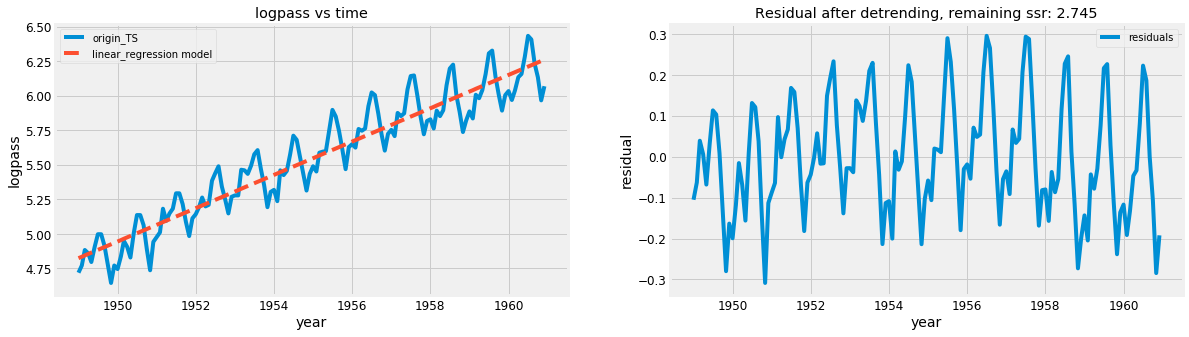

In [23]:
y1["year"] = range(len(y1)) 
reg = LinearRegression().fit(y1[["year"]], y1["logpass"])
predict_linearreg = reg.predict(y1[["year"]])
a,b = reg.intercept_,reg.coef_
Residuals_linearreg = y1["logpass"]-predict_linearreg
sum_square_residual_linearreg = sum([x**2 for x in Residuals_linearreg])
plt.subplots(1,2,figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(y1.index,y1["logpass"],"-",label="origin_TS")
plt.plot(y1.index,predict_linearreg,"--",label="linear_regression model")
plt.grid(True)
plt.title("logpass vs time")
plt.legend()
plt.xlabel("year")
plt.ylabel("logpass")
plt.subplot(1,2,2)
plt.plot(y1.index,Residuals_linearreg,"-",label="residuals")
plt.grid(True)
plt.title("Residuals(Linear Regression)")
plt.legend()
plt.xlabel("year")
plt.ylabel("residual")
ssr_residual = sum([x**2 for x in Residuals_linearreg])
plt.title("Residual after detrending, remaining ssr: %.3f"%ssr_residual)

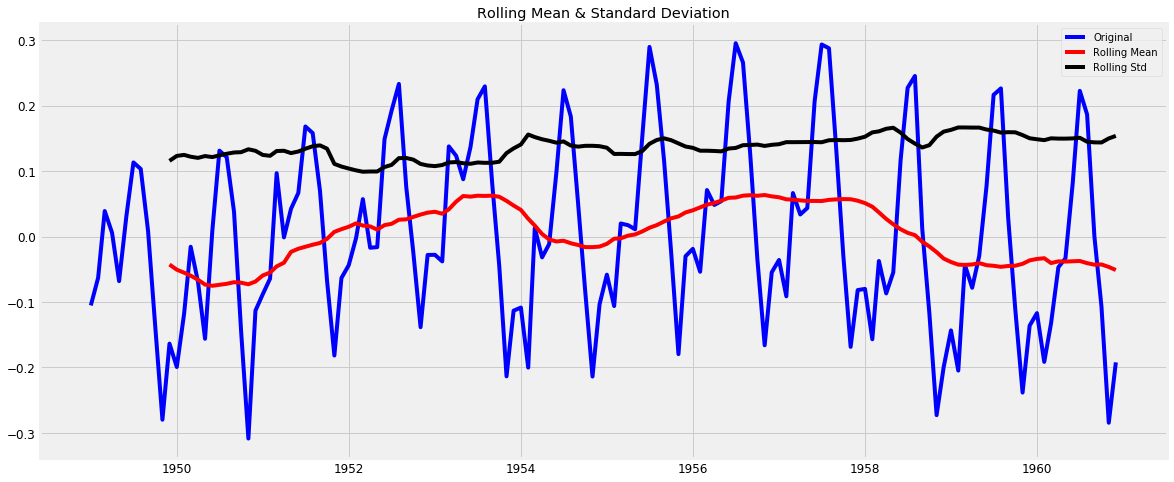

Results of Dickey-Fuller Test:
Test Statistic                  -2.260662
p-value                          0.184969
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [24]:
test_stationarity(Residuals_linearreg)

__Removing seasonality__

Text(0.5, 1.0, 'Residual after detrend & deseasonality, remaining SSR: 0.154')

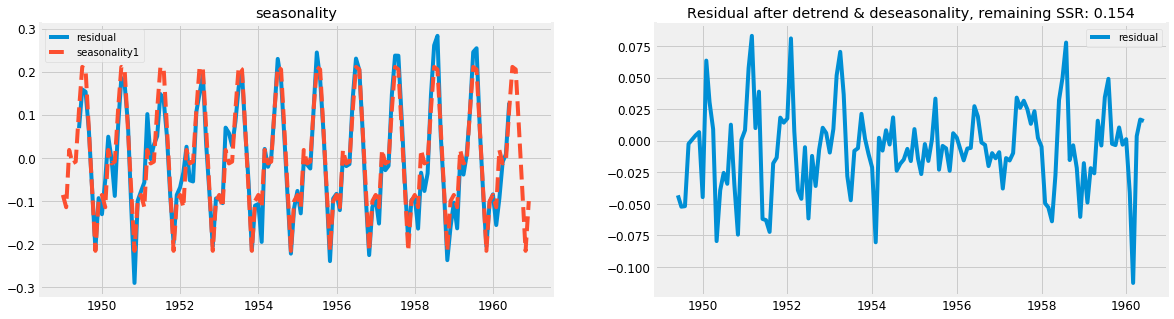

In [25]:
df['year'] = pd.to_datetime(df['year']).dt.month
y1['month'] = (df['year']).values
s_list = list()
for i in range(1,13):
    tmp = y1[y1["month"]==i].dropna()
    s_list.append(1/len(tmp)*sum(tmp["logpass"]-tmp["ma"]))
    s_mean = np.mean(s_list)  
monthly1_adjusted = pd.Series(index=range(1,13), data = s_list-s_mean)
y1["seasonality1"] = monthly1_adjusted.loc[y1["month"]].tolist()
y1["residual_2"] = y1["residual_1"] - y1["seasonality1"]
plt.subplots(1,2,figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(y1.index,y1["residual_1"],"-",label="residual")
plt.plot(y1.index,y1["seasonality1"],"--",label="seasonality1")
plt.grid(True)
plt.legend()
plt.title("seasonality")
plt.subplot(1,2,2)
plt.plot(y1.index,y1["residual_2"],label="residual")
plt.grid(True)
plt.legend()
ssr_residual = sum([x**2 for x in y1["residual_2"].dropna()])
plt.title("Residual after detrend & deseasonality, remaining SSR: %.3f"%ssr_residual)

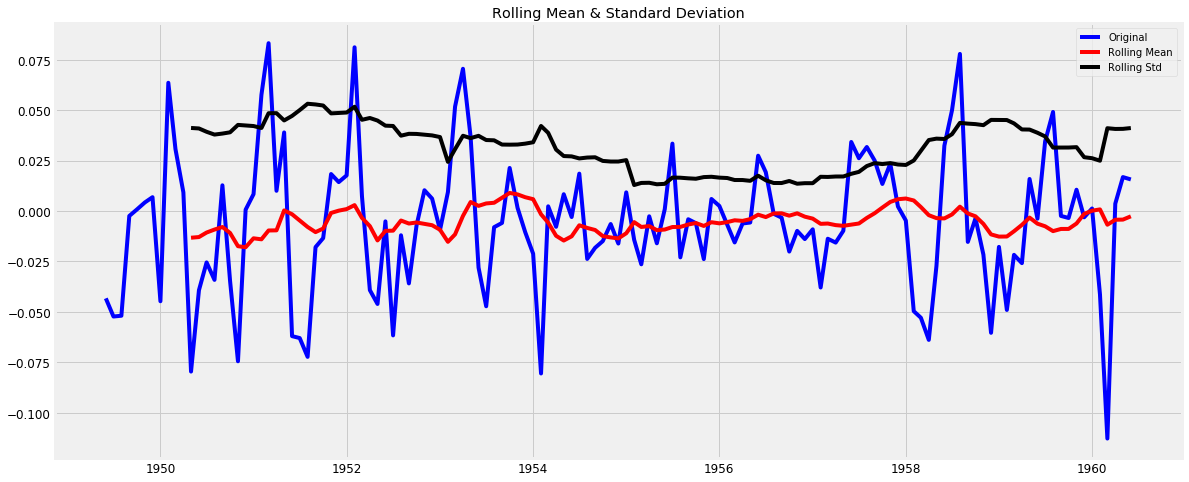

Results of Dickey-Fuller Test:
Test Statistic                -8.000186e+00
p-value                        2.345299e-12
#Lags Used                     7.000000e+00
Number of Observations Used    1.250000e+02
Critical Value (1%)           -3.483779e+00
Critical Value (5%)           -2.884954e+00
Critical Value (10%)          -2.579257e+00
dtype: float64


In [26]:
test_stationarity(y1["residual_2"].dropna())

In [27]:
# moving_avg = ts_log.rolling(12).mean()
# plt.plot(ts_log)
# plt.plot(moving_avg, color='red')

In [28]:
# ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
# ts_log_moving_avg_diff.head(12)

In [29]:
# ts_log_moving_avg_diff.dropna(inplace=True)
# test_stationarity(ts_log_moving_avg_diff)

In [30]:
# ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
# plt.plot(ts_log_diff)
# ts_log_diff.dropna(inplace=True)
# test_stationarity(ts_log_diff)

__Decomposition using statsmodels__

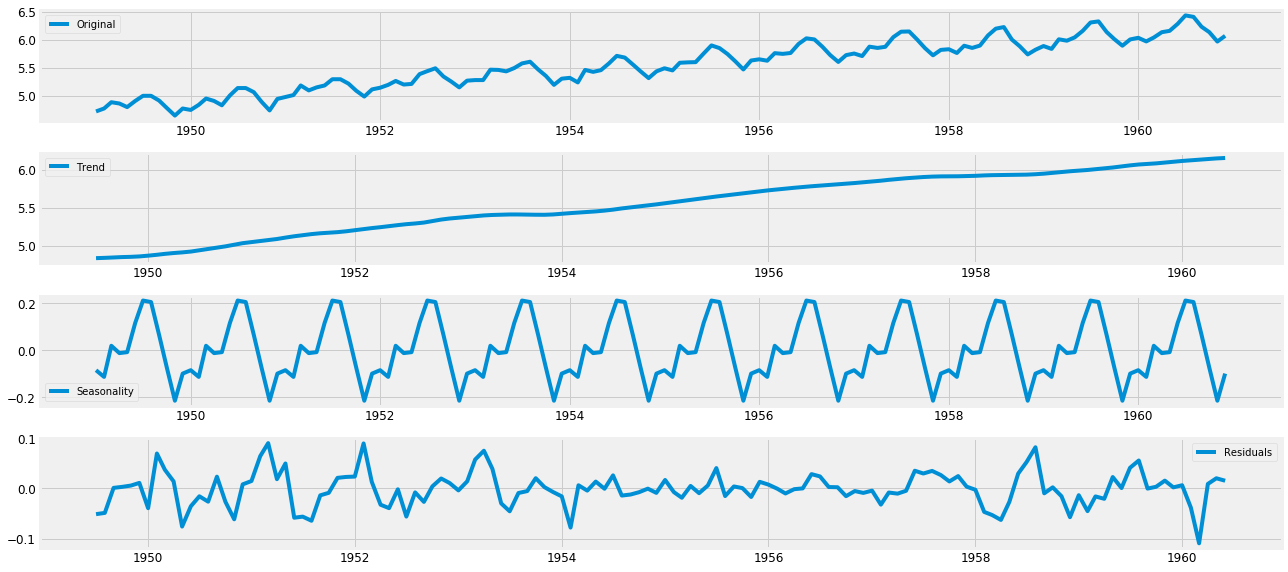

In [31]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


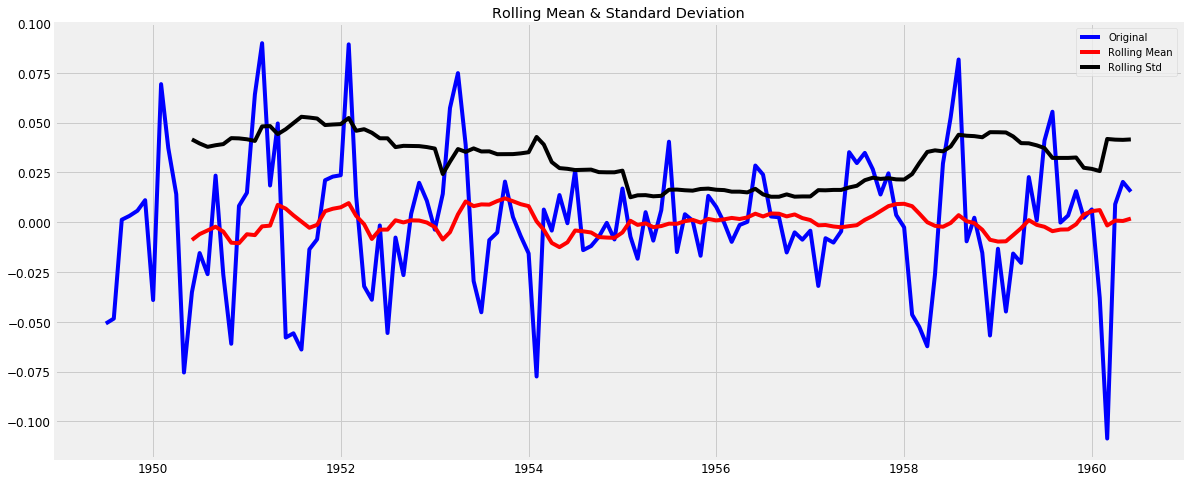

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [32]:
ts_log_decompose = residual #.passengers
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [33]:
# from statsmodels.tsa.ar_model import AR
# from random import random

In [34]:
# model = AR(ts_log_diff)
# model_fit = model.fit()

In [35]:
# plt.plot(ts_log_diff)
# plt.plot(model_fit.fittedvalues, color='red')
# plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
# plt.show()

In [36]:
# predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
# print (predictions_ARIMA_diff.head())

In [37]:
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# print (predictions_ARIMA_diff_cumsum.head())

In [38]:
# predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# predictions_ARIMA_log.head()

In [39]:
# predictions_ARIMA = np.exp(predictions_ARIMA_log)

In [40]:
# plt.plot(y.passengers)
# plt.plot(predictions_ARIMA)
# plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

In [41]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [42]:
# evaluate_forecast(y.passengers, predictions_ARIMA)

In [43]:
# from statsmodels.tsa.arima_model import ARMA
# from random import random

# # fit model
# model = ARMA(ts_log_diff, order=(0, 1))
# model_fit = model.fit(disp=False)

In [44]:
# model_fit.summary()

In [45]:
# plt.plot(ts_log_diff)
# plt.plot(model_fit.fittedvalues, color='red')
# plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

In [46]:
# from statsmodels.tsa.arima_model import ARMA
# from random import random

# # fit model
# model = ARMA(ts_log_diff, order=(2, 1))
# model_fit = model.fit(disp=False)

In [47]:

# model_fit.summary()

# ARIMA MODEL IMPLEMENTATION

In [48]:
#Estimate ARIMA differencing term

# Adf Test
print (ndiffs(y.passengers, test='adf'))

# KPSS test
print(ndiffs(y.passengers, test='kpss'))

# PP test:
print(ndiffs(y.passengers, test='pp')) 

0
1
0


## First difference plot

In [49]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

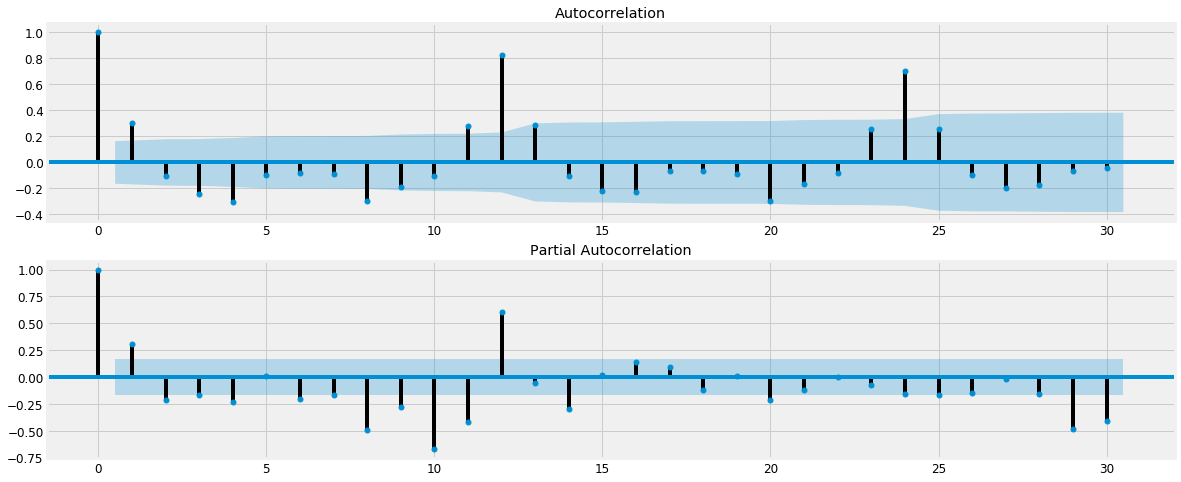

In [50]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

## Second difference plot to show that d=2 won't work!

In [51]:
ts2=ts-ts.shift()
ts2.dropna(inplace=True)

In [52]:
ts2.head()

year
1949-03-01     8.0
1949-04-01   -17.0
1949-05-01    -5.0
1949-06-01    22.0
1949-07-01    -1.0
Name: passengers, dtype: float64

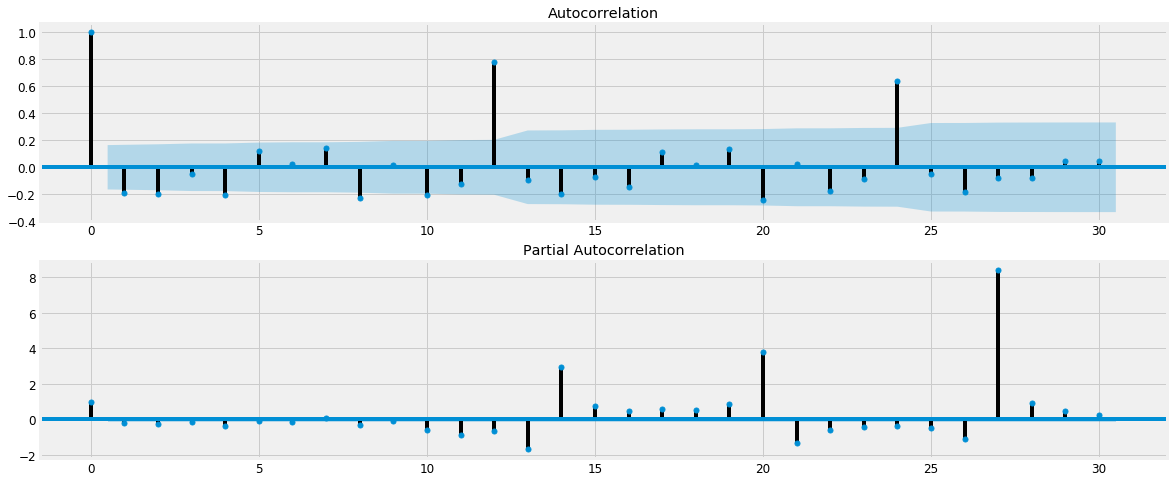

In [53]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts2, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts2, ax=pyplot.gca(),lags=30)
pyplot.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced. So we will have d=2

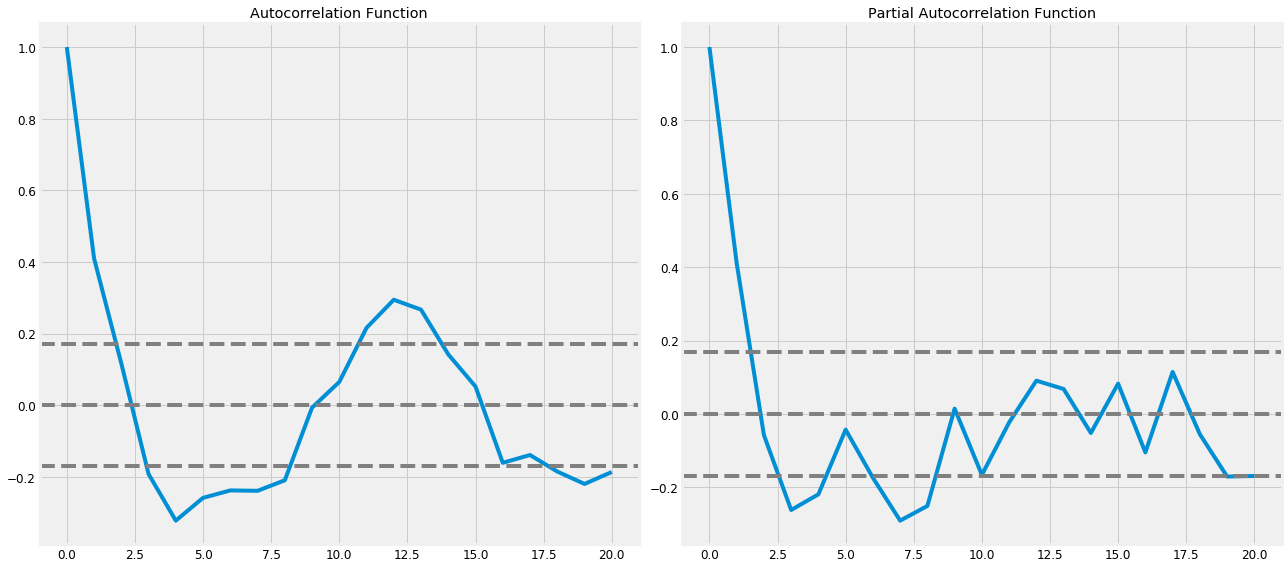

In [54]:
#Estimating p and q
#ACF and PACF plots:

ts_log_diff = y1["residual_2"].dropna()

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')


#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time (p=2).

q – The lag value where the ACF chart crosses the upper confidence interval for the first time(q=2).

# Hence p=q=2 

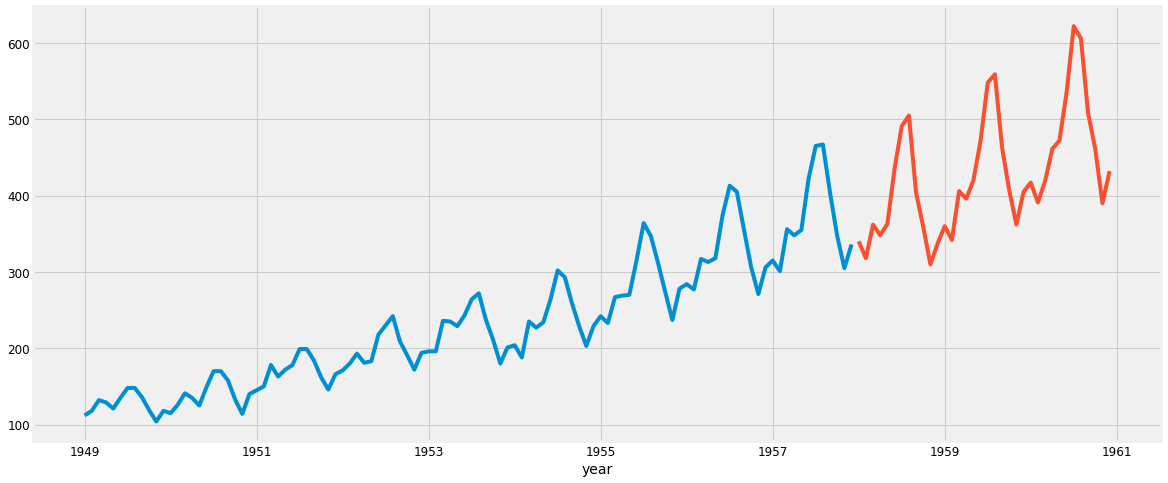

In [55]:
#divide into train and validation set for out-of-sample validation
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [56]:
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit(disp=1)

C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [57]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  107
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -473.609
Method:                       css-mle   S.D. of innovations             19.832
Date:                Wed, 13 May 2020   AIC                            959.218
Time:                        20:07:35   BIC                            975.255
Sample:                    02-01-1949   HQIC                           965.720
                         - 12-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5020      0.688      3.637      0.000       1.154       3.850
ar.L1.D.passengers     1.6405      0.044     37.329      0.000       1.554       1.727
ar.L2.D.passengers    -0.9086      0.042    -21.383      0.000      -0.992      -0.825
ma.L1.D.passengers    -1.8338      0.044    -42.064      0.000      -1.919      -1.748
ma.L2.D.passengers     0.9290      0.048     19.327      0.000       0.835       1.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9027           -0.5344j            1.0491           -0.0851
AR.2            0.9027           +0.5344j            1.0491            0.0851
MA.1            0.9870           -0.3198j            1.0375           -0.0499
MA.2            0.9870           +0.3198j            1.0375            0.0499
-----------------------------------------------------------------------------
"""

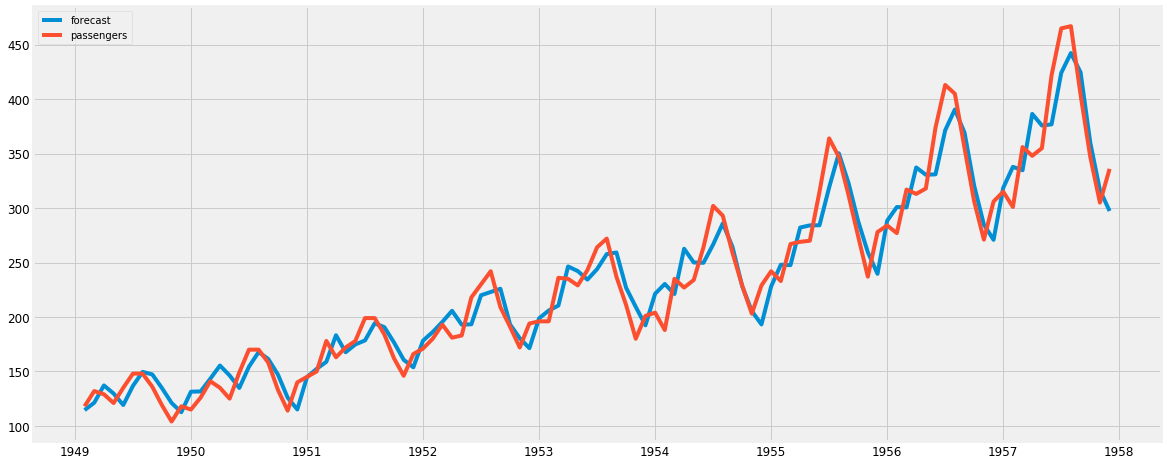

In [58]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [59]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [60]:
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 432.70497424634084, MSE:187233.59473752647


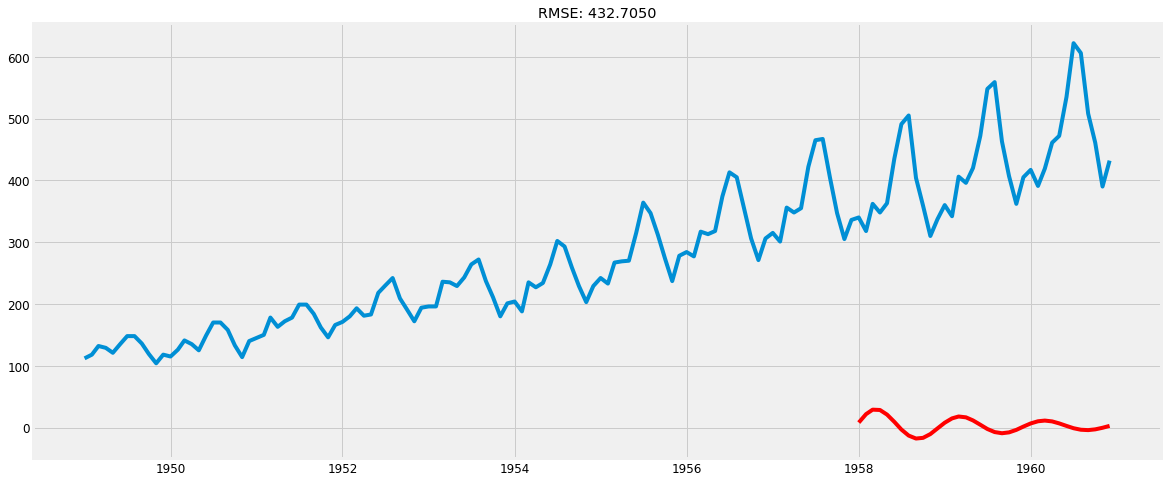

In [61]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [62]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-01-01     8.104154
1958-02-01    21.741319
1958-03-01    28.974521
1958-04-01    28.449648
1958-05-01    21.016232
Freq: MS, dtype: float64


In [63]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-01-01      8.104154
1958-02-01     29.845473
1958-03-01     58.819994
1958-04-01     87.269642
1958-05-01    108.285875
Freq: MS, dtype: float64


In [64]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01    348.104154
1958-02-01    369.845473
1958-03-01    398.819994
1958-04-01    427.269642
1958-05-01    448.285875
dtype: float64

Text(0.5, 1.0, 'RMSE: 223.4292')

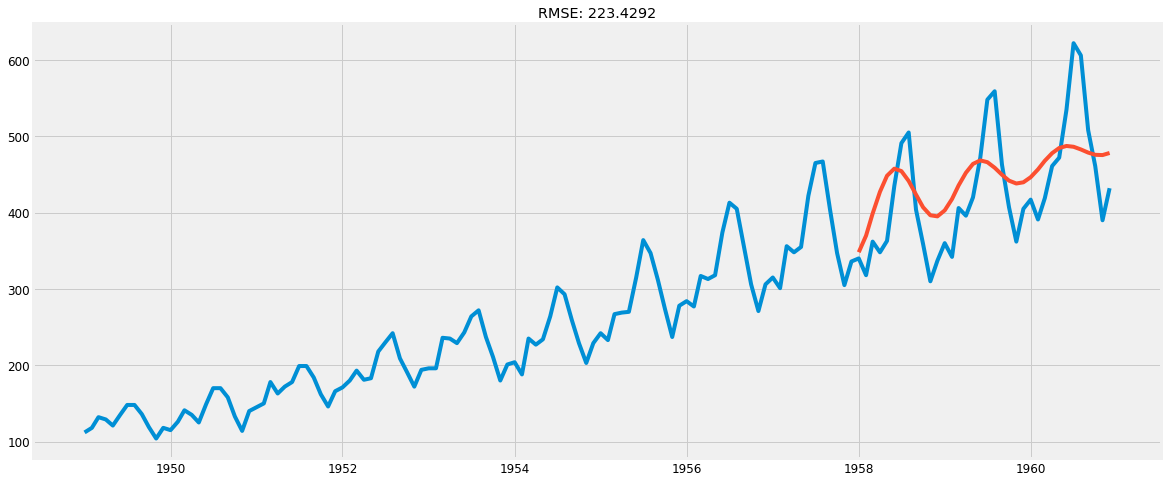

In [65]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [66]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.408817,51.263773,46.90403,3617.041069,0.018503,NaN,60.141841


# SARIMA: parameters chosen according to the model having the least AIC value 

In [67]:
import itertools

p = q = range(0, 2)
d=[1]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Here, the cycle we found during the previous analysis was of 12 month, hence, 12 chosen as the seasonal parameter. 

## Results are also better for seasonal parameter = 12 instead of 6 

In [68]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\t

SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:701.0445186509195
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:617.608456541524
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:624.300562156908
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:619.6081873871647
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:691.2552635297669
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:607.6579717827885


C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\t

SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:621.9698671435227


C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:606.8440567815395
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:697.3165948980068
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:615.0473569046245


C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\t

SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:614.7555023919764


C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:614.5650200269631
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:691.9651250305867


C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:608.2197420760326
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:615.7598482490495


C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\titas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:610.2191727917418


In [69]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -299.422
Date:                            Wed, 13 May 2020   AIC                            606.844
Time:                                    20:07:37   BIC                            616.422
Sample:                                01-01-1949   HQIC                           610.687
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2600      0.098     -2.657      0.008      -0.452      -0.068
ar.S.L12      -0.6461      0.128     -5.047      0.000      -0.897      -0.395
ma.S.L12       0.6905      0.266      2.594      0.009       0.169       1.212
sigma2        87.3032     22.819      3.826      0.000      42.578     132.028
===================================================================================
Ljung-Box (Q):                       48.05   Jarque-Bera (JB):                 2.64
Prob(Q):                              0.18   Prob(JB):                         0.27
Heteroskedasticity (H):               0.84   Skew:                             0.34
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

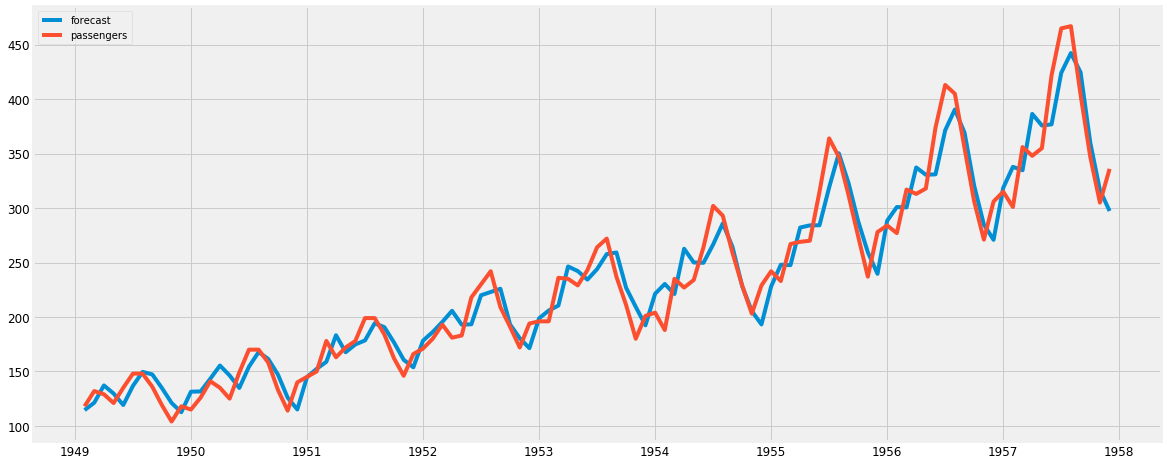

In [70]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [71]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

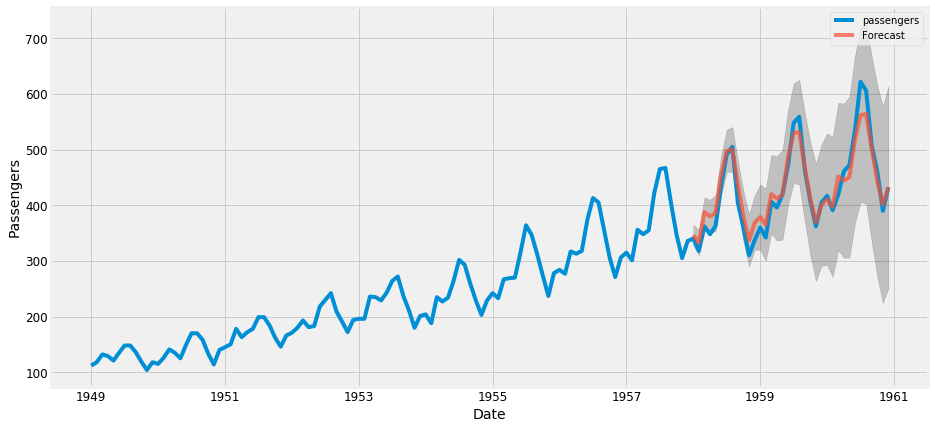

In [72]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

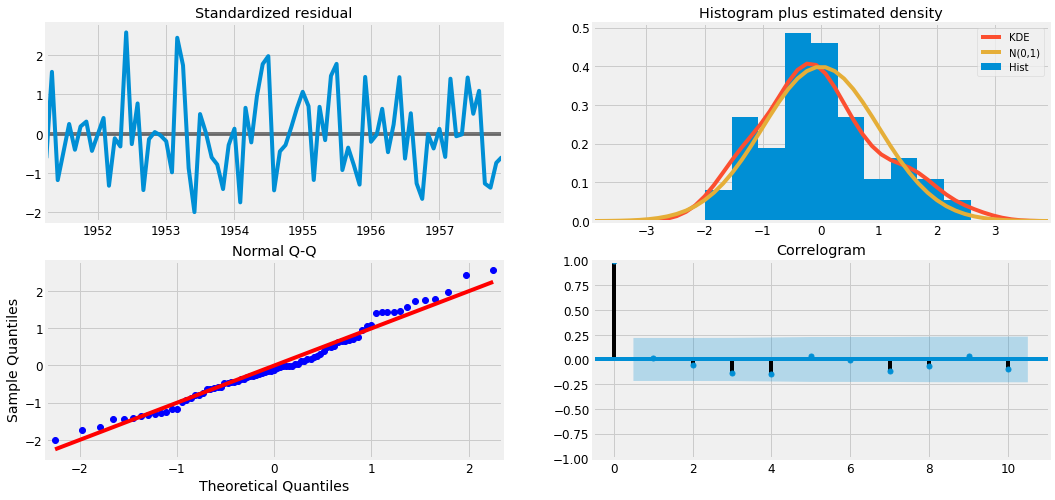

In [73]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [74]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].passengers.values
mse = ((y_forecasted - y_truth) ** 2).mean()
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.923208,17.717283,16.6924,469.834005,0.002447,4.20006,21.675655
